In [ ]:
import pandas as pd
import numpy as np
import math
import re
import random
import nltk
from bnlp import BasicTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Soft Computing/Assignment 3/Dataset_1.csv', encoding = "ISO-8859-1", engine='python')
df = df.sample(frac=1)

# Preprocessing

In [ ]:
# removing mentions, links, tags

import re

def removing_mentions(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
    text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
    text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
    text = re.sub(r'@[-)]+', '', text)            # removing @mentions

    return text

def removeing_links(text):
    text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
    text = re.sub(r'http?\/\/\S+', '', text)     # removing the hyper link
    
    return text

def removing_tags(text):
    text = re.sub(r'#', '', text )              # removing '#' sign
    text = re.sub(r'RT[\s]+', '', text)         # removing RT
    text = re.sub(r'&[a-z;]+', '', text)        # removing '&gt;'
    
    return text

# Stopwords removal

In [ ]:
!pip install -U bnlp_toolkit

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    tokenizer = BasicTokenizer()
    words = tokenizer.tokenize(text)
    filtered_words = [w for w in words if not w in stopwords]

    str = " "
    return str.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df[['message', 'label']].iloc[range(5)]

,message,label
1495,i spy with my little eye something beginning w...,0
5161,"@ellyasabdullah Apologies 4 my impudence, U SI...",0
7787,My copy of LVATT is in the post! Heard the son...,0
8930,@homiebirdo Depression,1
553,@kristenstewart9 Hello Kristen love your work,0


In [ ]:
df['message'] = df['message'].apply(removeing_links)
df['message'] = df['message'].apply(removing_mentions)
df['message'] = df['message'].apply(removing_tags)


df['message'] = df['message'].apply(remove_stopwords)

In [ ]:
df[['message', 'label']].iloc[range(5)]

,message,label
1495,spy little eye something beginning M hint im l...,0
5161,"Apologies 4 impudence , U SINGLE ? ? NOO ! ! C...",0
7787,My copy LVATT post ! Heard songs live last nig...,0
8930,Depression,1
553,Hello Kristen love work,0


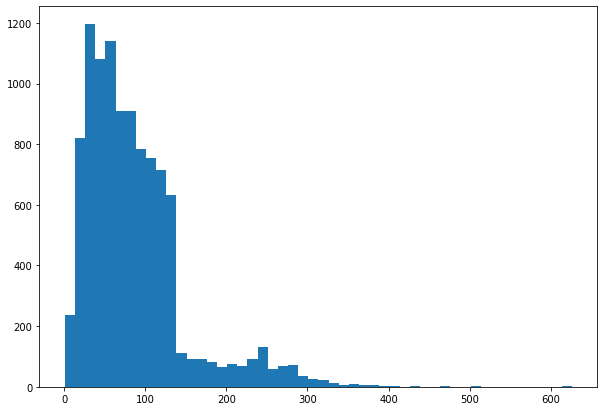

In [ ]:
df1 = df
df1['length'] = 0

a = 0
for i, row in df1.iterrows():
    l = len(row['message'])
    df1.at[i,'length'] = l

length_array = df1['length'].to_numpy()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(length_array, bins=50)
 
# Show plot
plt.show()

In [ ]:
df[['message', 'label', 'length']].iloc[range(5)]

,message,label,length
2718,"_the_kid failure yesterday sorry, ahaha",0,40
7829,"3 days till Britney, excited",0,29
6828,Sushi-time! cant go wrong with that,0,36
310,Anyway sarah prout we all wish you the best of...,0,99
4168,Still walking on a cloud Dinner on 6/10 w/John...,0,137


## Vectorization

In [ ]:
dataset = df
unique_label = np.unique(df["label"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['message'].values, pd.get_dummies(dataset['label']).values, test_size=0.20)

MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print("found ", len(word_index), " unique tokens")

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)


print(pad_train.shape,y_train.shape)
print(pad_test.shape,y_test.shape)

found  18175  unique tokens
Shape of data tensor: (8251, 100)
(8251, 100) (8251, 2)
(2063, 100) (2063, 2)


## Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))
model.add(LSTM(100, activation= 'tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100, activation= 'tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100, activation= 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

epochs = 15
batch_size = 128

history = model.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 100)          80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)              

In [ ]:
evaluation = model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

65/65 [==============================] - 4s 29ms/step - loss: 0.0437 - accuracy: 0.9947
Accuracy is :  99.46679472923279


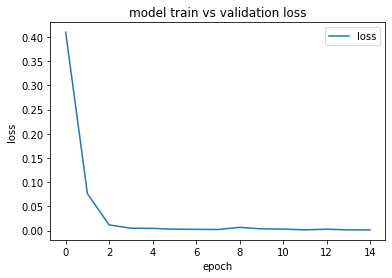

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'validation'], loc='upper right')
pyplot.show()

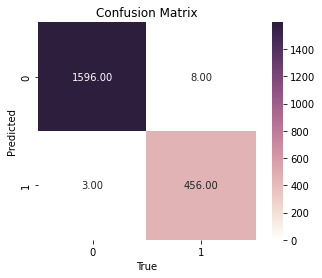

In [ ]:
y_pred = model.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)



fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)
res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [ ]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1599
           1       0.99      0.98      0.99       464

    accuracy                           0.99      2063
   macro avg       0.99      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



In [ ]:
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print(precision)
print(f1_score)
print(recall)

99.34640522875817
98.80823401950163
98.27586206896551


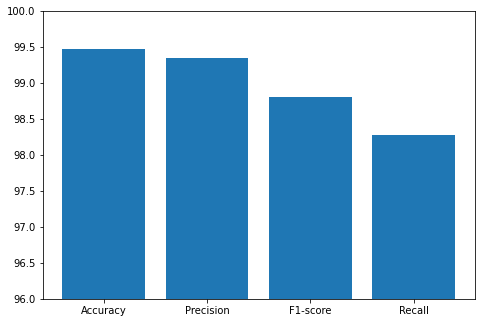

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Accuracy', 'Precision', 'F1-score', 'Recall']
value = [accuracy,precision,f1_score,recall]
ax.bar(label,value)
plt.ylim(96,100)
plt.show()